In [3]:
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import FunctionTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from collections import Counter
import imblearn
from imblearn.over_sampling import SMOTE,RandomOverSampler

from nltk import word_tokenize
from time import time
import pandas as pd
import re
import numpy as np
import gensim
import string

In [4]:
import nltk
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

In [5]:
training_set = pd.read_csv("Train.csv")
training_set.sample(5)

,ID,Text,Label
957,ID_jZTnOWfF,Basi ayisempha Tsiku limenelo sitidakhale pa ...,CULTURE
1382,ID_yMYOAIGZ,NICE Trust Ilimbikitsa za Bata Pambuyo pa Chig...,POLITICS
1087,ID_pAQhxYzP,TCC imema alimi a fodya kulembetsa Bungwe loy...,FARMING
373,ID_OOvbbxBn,Moto wayaka ku Nkosini Pasanadutse nkomwe mwe...,LOCALCHIEFS
53,ID_CYotyuIl,Aphungu avuta Tsikulo pa Wenela padali ziii! ...,POLITICS


In [6]:
training_set.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1436 entries, 0 to 1435
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   ID      1436 non-null   object
 1   Text    1436 non-null   object
 2   Label   1436 non-null   object
dtypes: object(3)
memory usage: 33.8+ KB


In [7]:
test_set = pd.read_csv("Test.csv")
test_set.sample(5)

,ID,Text
126,ID_JhRAELrS,Atsogoleri a ndale akuona 2020 owala Atsogole...
472,ID_oLiOoGZT,"Chenjerani, 2017 tisatuwe ndi njala Lero ndi..."
282,ID_XgZHGzNj,Emmanuel Ngwira: Katswiri wa vimbuza Gule wa ...
457,ID_nLKyfYhG,Minibasi zivuta pa Wenela Si kuti ndikamba za...
29,ID_CMBLAzAY,Kupewa chigodola cha nkhumba ndikotheka Mmwez...


Text(0.5, 1.0, 'Classes distribution')

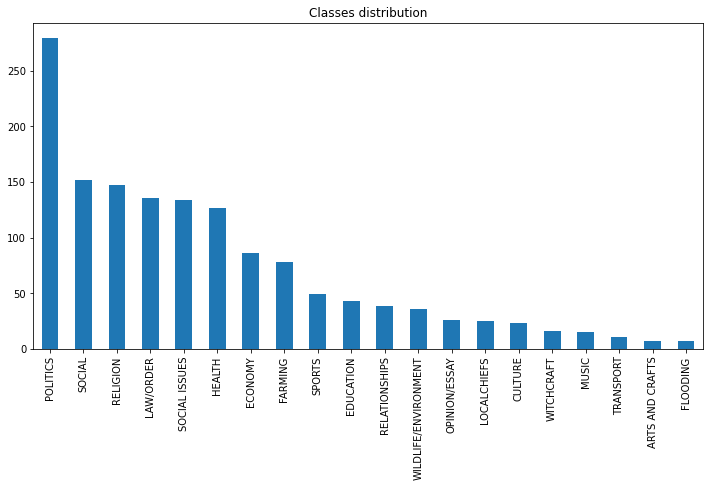

In [8]:
training_set.Label.value_counts().plot.bar(figsize=(12, 6))
plt.title('Classes distribution')

In [9]:
punctuations = string.punctuation + "’¶•@°©®™"

In [10]:
def preprocess_text(text):
    """
    @param text string
    @return text string
    
    This function preprocess a given raw text by normalizing it to lowercase removing the stop words,
    punctuations and lemmatization
    """
        
    #string to lowercase
    txt = text.lower()
    
    # keep only ascii characters
    txt = re.sub(r"[^a-zA-ZÀ-ÿ]", " ", txt)
    
    # punctuation removal and map it to space
    translator = str.maketrans(punctuations, " "*len(punctuations))
    s = txt.translate(translator)
    
    # remove digits 
    no_digits = ''.join([i for i in s if not i.isdigit()])
    cleaner = " ".join(no_digits.split())
    
    # tokenize words and removing stop words 
    word_tokens = word_tokenize(cleaner)
    filtered_sentence = [w for w in word_tokens if len(w)>2 ]
    filtered_sentence = " ".join(filtered_sentence)
    
    return filtered_sentence

In [11]:
# testing function
sample_text = training_set.Text[7]
print("RAW text before preprocessing :\n")
print(sample_text)
print("\n-------------------------------\n")
print("Processed text after preprocessing :\n")
print(preprocess_text(sample_text))

RAW text before preprocessing :

 Mayi wamalonda avulazidwa ku bt Titha Masamba, wa zaka 31, akumva ululu wadzaoneni. Kuti ayende akuyenera agwirire ndodo; sangagone chafufumimba koma chammbali kapena chagada; moyo wamtendere watha.
 Akuti adamuphera tsogolo lake: Masamba kumva ululu kunyumba kwake Akuti izitu zili chonchi chifukwa cha bala lomwe lili pabondo lake la kumanja lomwe lidasokedwa kuchipatala pambuyo pokhapidwa ndi chikwanje.
  Chisale watuluka nkumangidwanso  Sipakala waimitsa Nyumba ya Malamulo  Pa Wenela pasintha zedi Ulendo wa mayiyu wokagulitsa mandasi pa 7 July ndi womwe udabweretsa mavutowa pomwe anthu ena, omwe akuwaganizira kuti ogwira ntchito kukhonsolo ya mzinda wa Blantyre (city rangers) amene adamuchita chiwembu pomulanda malonda ake komanso kumuvulaza ndi chikwanje.
 Masamba akuti atangomwalira amuna ake mu 2007, iye adayamba geni yogulitsa mandasi kuti azisamalira banja lake la ana awiri. Malo amene amagulitsira malonda akewo akuti ndi ku Cold Storage pafupi 

In [12]:
# Applying the preprocessing function through all the data
training_set['clean_text'] = training_set.Text.apply(preprocess_text)
test_set['clean_text'] = test_set.Text.apply(preprocess_text)

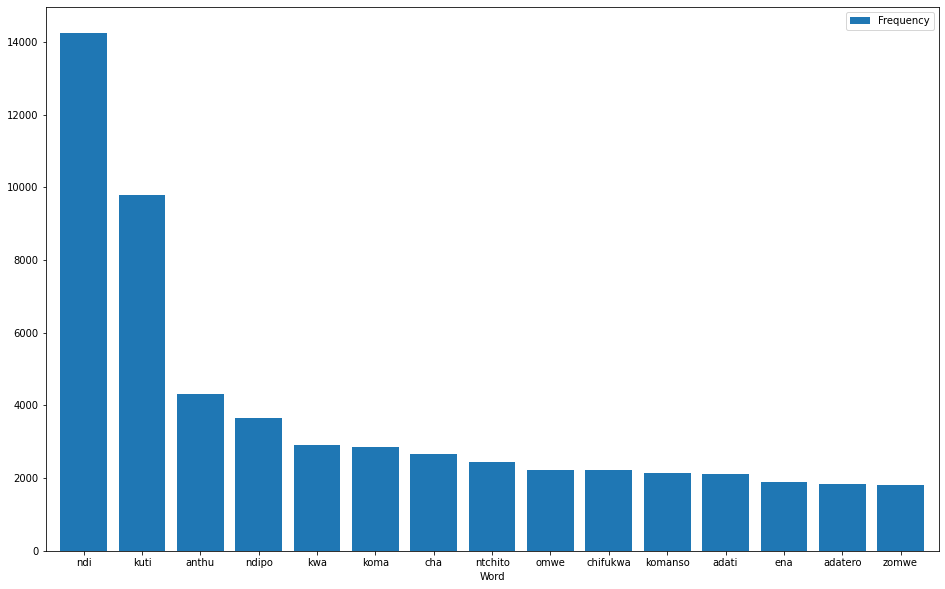

In [13]:
rslt = pd.DataFrame(Counter(" ".join(training_set["clean_text"]).split()).most_common(15),
                    columns=['Word', 'Frequency']).set_index('Word')

rslt.plot.bar(rot=0, figsize=(16,10), width=0.8)

In [14]:
training_set['clean_text'] = training_set['clean_text'].str.replace('ndi', '').replace('kuti', '')
test_set['clean_text'] = test_set['clean_text'].str.replace('ndi', '').replace('kuti', '')

In [15]:
training_set.sample(5)

,ID,Text,Label,clean_text
147,ID_FyVNbdpW,Ulendo wa chisankho wapsa Zipani zina zati bu...,POLITICS,ulendo chisankho wapsa zipani zina zati bungwe...
1392,ID_ydDbBLpD,Usi Wapempha Amalawi Alemekeze Mutharika Pomuc...,POLITICS,usi wapempha amalawi alemekeze mutharika pomuc...
75,ID_DMuXMJtH,Zionetsero zaima Anthu zikwizikwi adabwerera ...,POLITICS,zionetsero zaima anthu zikwizikwi adabwerera m...
479,ID_SOmlxrhf,"Sitalaka yatha, yaika amalawi pamoto Pomwe og...",POLITICS,sitalaka yatha yaika amalawi pamoto pomwe ogwi...
524,ID_TUdmErgA,2019 ikudetsa nkhawa Chikhulupiliro chapita. ...,ECONOMY,ikudetsa nkhawa chikhulupiliro chapita amalawi...


## Grid Search

In [16]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer

pipeline = Pipeline(
    [
        ("vect", CountVectorizer()),
        ("tfidf", TfidfTransformer()),
        ("classifier", LogisticRegression()),
    ]
)

In [ ]:
parameters = {
   'classifier__penalty' : ['l1', 'l2'],
   'classifier__C' : np.logspace(-4, 4, 20),
   'classifier__solver' : ['liblinear']
}

In [ ]:
from sklearn.model_selection import GridSearchCV
from pprint import pprint

grid_search = GridSearchCV(pipeline, parameters, n_jobs=-1, verbose=1)

In [ ]:
print("Performing grid search...")
print("pipeline:", [name for name, _ in pipeline.steps])
print("parameters:")
pprint(parameters)
t0 = time()
grid_search.fit(training_set['clean_text'], training_set['Label'])
print("done in %0.3fs" % (time() - t0))
print()

print("Best score: %0.3f" % grid_search.best_score_)
print("Best parameters set:")
best_parameters = grid_search.best_estimator_.get_params()
for param_name in sorted(parameters.keys()):
    print("\t%s: %r" % (param_name, best_parameters[param_name]))

Performing grid search...
pipeline: ['vect', 'tfidf', 'classifier']
parameters:
{'classifier__C': array([1.00000000e-04, 2.63665090e-04, 6.95192796e-04, 1.83298071e-03,
       4.83293024e-03, 1.27427499e-02, 3.35981829e-02, 8.85866790e-02,
       2.33572147e-01, 6.15848211e-01, 1.62377674e+00, 4.28133240e+00,
       1.12883789e+01, 2.97635144e+01, 7.84759970e+01, 2.06913808e+02,
       5.45559478e+02, 1.43844989e+03, 3.79269019e+03, 1.00000000e+04]),
 'classifier__penalty': ['l1', 'l2'],
 'classifier__solver': ['liblinear']}
Fitting 5 folds for each of 40 candidates, totalling 200 fits
done in 76.296s

Best score: 0.646
Best parameters set:
	classifier__C: 545.5594781168514
	classifier__penalty: 'l2'
	classifier__solver: 'liblinear'


## Without Oversampling

In [18]:
%%time
pipeline = Pipeline(
    [
        ("vect", CountVectorizer()),
        ("tfidf", TfidfTransformer()),
        ("classifier", LogisticRegression(C=545.5594781168514, solver='liblinear', penalty='l2')),
    ]
)

CPU times: user 211 µs, sys: 0 ns, total: 211 µs
Wall time: 218 µs


In [ ]:
scores = cross_val_score(pipeline, training_set['clean_text'], training_set['Label'], cv=5, scoring='precision_micro')
print(scores)

[0.62847222 0.63414634 0.67247387 0.64808362 0.64808362]


In [ ]:
print(f"Final score is {scores.mean()}")

Final score is 0.646251935733643


## With Oversampling

In [19]:
%%time
pipeline = imblearn.pipeline.Pipeline(
    [
        ("vect", CountVectorizer()),
        ("tfidf", TfidfTransformer()),
        ('ros', RandomOverSampler()),
        ('oversampler', SMOTE()),
        ("classifier", LogisticRegression(C=1.623776739188721, solver='liblinear', penalty='l2')),
    ]
)

CPU times: user 249 µs, sys: 0 ns, total: 249 µs
Wall time: 288 µs


In [20]:
scores = cross_val_score(pipeline, training_set['clean_text'], training_set['Label'], cv=5, scoring='precision_micro')
print(scores)

[0.62152778 0.62369338 0.67595819 0.66202091 0.64111498]


In [21]:
print(f"Final score is {scores.mean()}")

Final score is 0.6448630468447542


## Predict test data

In [22]:
pipeline.fit( training_set['clean_text'], training_set['Label'])
test_set.loc[:,"Label"] = pipeline.predict(test_set['Text'])

In [23]:
test_set[['ID','Label']]

,ID,Label
0,ID_ADHEtjTi,SOCIAL ISSUES
1,ID_AHfJktdQ,RELIGION
2,ID_AUJIHpZr,RELATIONSHIPS
3,ID_AUKYBbIM,SOCIAL ISSUES
4,ID_AZnsVPEi,HEALTH
...,...,...
615,ID_zdpOUWyJ,LAW/ORDER
616,ID_zhnOomuu,RELATIONSHIPS
617,ID_zmWHvBJb,LAW/ORDER
618,ID_zphjdFIb,SOCIAL ISSUES


In [24]:
#test_set[['ID','Label']].to_csv("submission.csv", index=False) 